
Model Performance Comparison:

Linear Regression:
MAE: 500592.8598
RMSE: 608037.7683
R2 Score: -24.9871

Random Forest:
MAE: 23902.8571
RMSE: 30600.4825
R2 Score: 0.9342

XGBoost:
MAE: 70504.2266
RMSE: 108321.6685
R2 Score: 0.1752

Neural Network:
MAE: 96759.1337
RMSE: 153381.8044
R2 Score: -0.6537


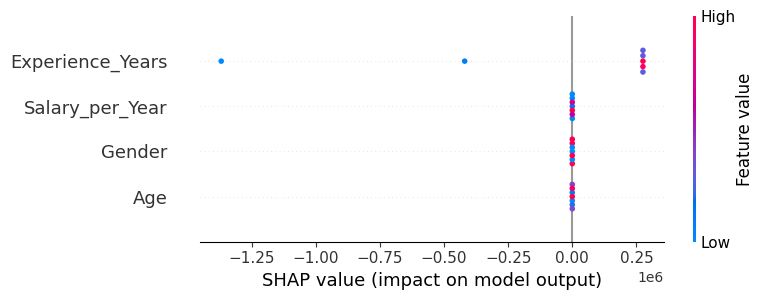

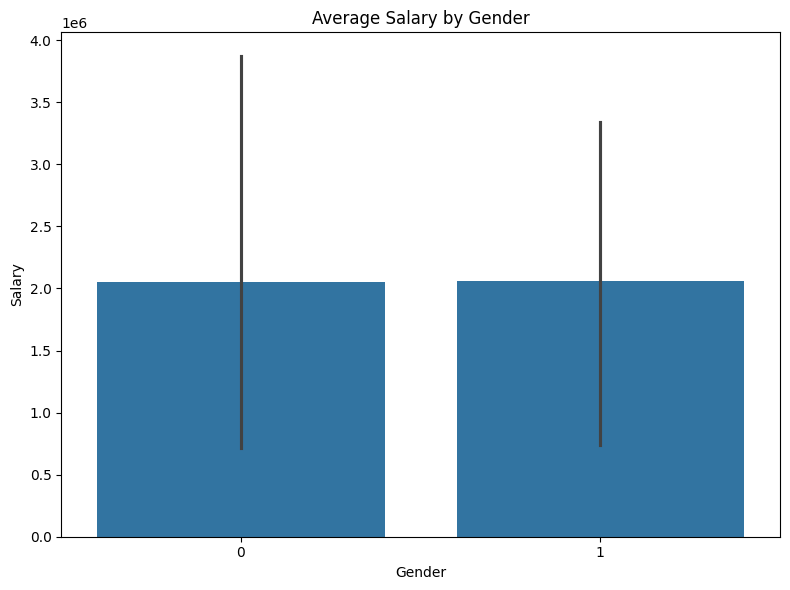

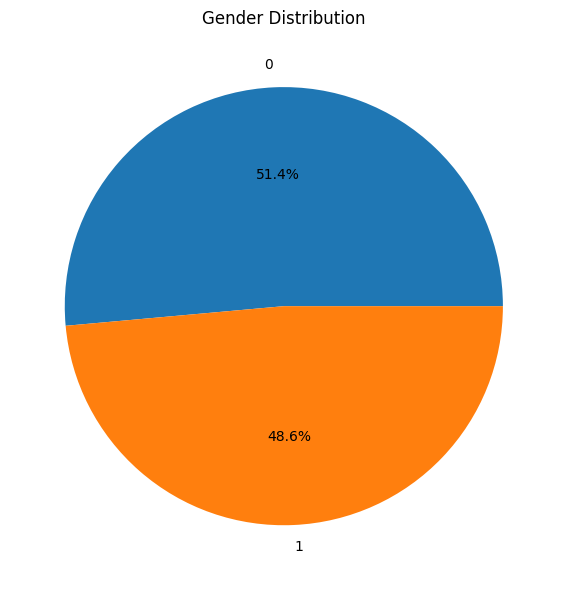

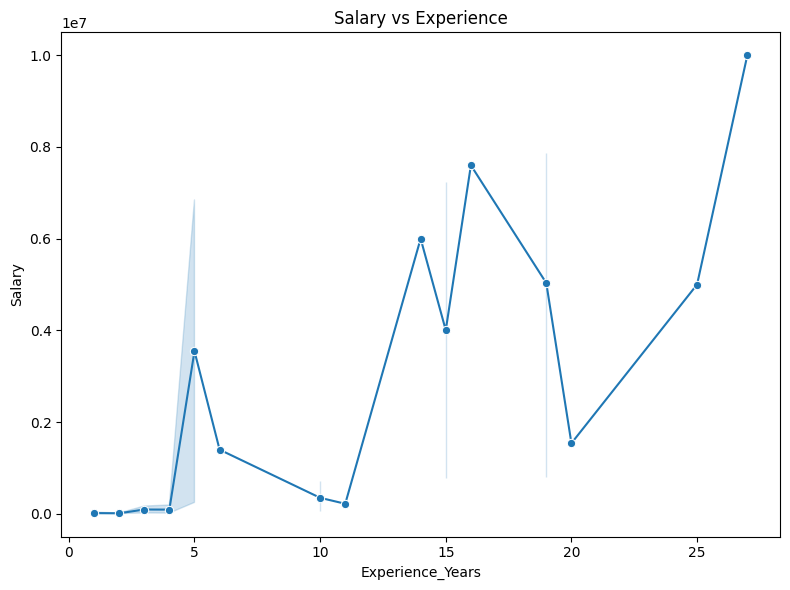

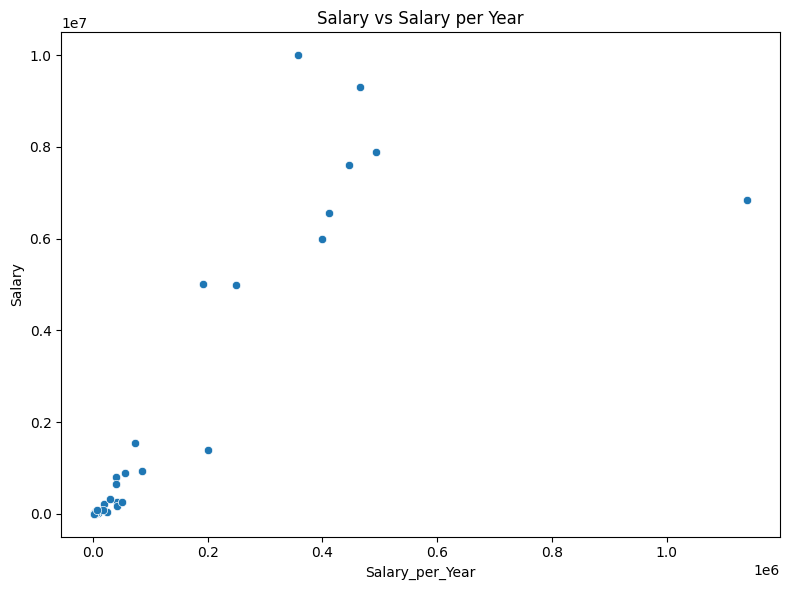

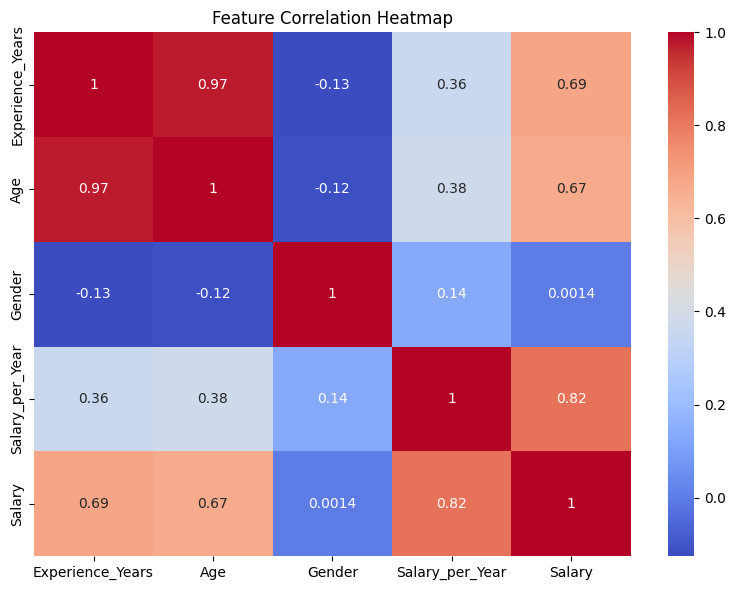

In [2]:
# -----------------------------
# STEP 1: Load Libraries
# -----------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb
import shap
import optuna
import warnings
warnings.filterwarnings("ignore")

# -----------------------------
# STEP 2: Load Dataset
# -----------------------------
df = pd.read_csv(r"D:\VSCODE\Datanalaysis\AIML IBM\Dataset\Employee_Salary_Dataset.csv")

# -----------------------------
# STEP 3: Feature Engineering
# -----------------------------
df['Salary_per_Year'] = df['Salary'] / (df['Experience_Years'] + 1)
df['Gender'] = LabelEncoder().fit_transform(df['Gender'])

# -----------------------------
# STEP 4: Preprocessing
# -----------------------------
features = ['Experience_Years', 'Age', 'Gender', 'Salary_per_Year']
X = df[features]
y = df['Salary']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# -----------------------------
# STEP 5: Train Multiple Models
# -----------------------------
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': xgb.XGBRegressor(random_state=42),
    'Neural Network': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=500, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    results[name] = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2 Score': r2_score(y_test, y_pred)
    }

print("\nModel Performance Comparison:")
for name, metrics in results.items():
    print(f"\n{name}:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")

# -----------------------------
# STEP 6: SHAP Explainability (for XGBoost)
# -----------------------------
xgb_model = models['XGBoost']
explainer = shap.Explainer(xgb_model, X_train)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, show=False)
plt.tight_layout()
plt.savefig("shap_summary.png")

# -----------------------------
# STEP 7: AutoML with Optuna (Optional)
# -----------------------------
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0)
    }
    model = xgb.XGBRegressor(**params, random_state=42)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    return mean_squared_error(y_test, preds)

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=10)
# print("Best parameters:", study.best_params)

# -----------------------------
# STEP 8: Visualization Plots
# -----------------------------
plt.figure(figsize=(8,6))
sns.barplot(x='Gender', y='Salary', data=df)
plt.title('Average Salary by Gender')
plt.tight_layout()
plt.savefig("bar_salary_by_gender.png")

plt.figure(figsize=(8,6))
df['Gender'].value_counts().plot.pie(autopct="%1.1f%%")
plt.title("Gender Distribution")
plt.ylabel("")
plt.tight_layout()
plt.savefig("pie_gender_distribution.png")

plt.figure(figsize=(8,6))
sns.lineplot(x='Experience_Years', y='Salary', data=df, marker='o')
plt.title("Salary vs Experience")
plt.tight_layout()
plt.savefig("line_salary_experience.png")

plt.figure(figsize=(8,6))
sns.scatterplot(x='Salary_per_Year', y='Salary', data=df)
plt.title("Salary vs Salary per Year")
plt.tight_layout()
plt.savefig("scatter_salary_per_year.png")

plt.figure(figsize=(8,6))
sns.heatmap(df[features + ['Salary']].corr(), annot=True, cmap="coolwarm")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.savefig("heatmap_correlation.png")

# -----------------------------
# END OF PIPELINE
# -----------------------------